Imported libraries

In [81]:
import os
import random
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from cryptography.hazmat.primitives import hashes
from timeit import default_timer as timer

Generating a .txt file of a given size with random content

In [82]:
def generate_random_files(byte_size):
    return ''.join(random.choices(string.ascii_letters + string.digits + string.punctuation + ' ', k=byte_size))

def write_to_file(directory, filename, byte_size):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    file_path = os.path.join(directory, filename)
    random_text = generate_random_files(byte_size)

    with open(file_path, 'w') as file:
        file.write(random_text)

Function that encrypts the file using SHA-256

In [83]:
def compute_sha256(file_path):
    digest = hashes.Hash(hashes.SHA256())
    
    with open(file_path, 'rb') as file:
        data = file.read()

    start = timer()
    digest.update(data)
    hashing = digest.finalize()
    end = timer()

    elapsed_time_us = (end - start) * 1000000  
    return elapsed_time_us, hashing

Storing the encrypted contents of each file

In [84]:
""" storing_directory = 'encrypted_files'

if not os.path.exists(storing_directory):
    os.makedirs(storing_directory)
    file_path=os.path.join(storing_directory,filename)

 """

" storing_directory = 'encrypted_files'\n\nif not os.path.exists(storing_directory):\n    os.makedirs(storing_directory)\n    file_path=os.path.join(storing_directory,filename)\n\n "

Printing the results:

Uses the filename to obtain the integer size

In [85]:
def get_size(filename):
    return int(filename.split('_')[-1].split('.')[0])

Applies SHA_256 to a specfic file through its filename

In [86]:
def file_time(filename, directory):
    if filename.startswith("random_text_") and filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        time, _ = compute_sha256(file_path)
        return time
    return 0

Calculates the average time of the procedure for a given number of iterations

In [87]:
def avg_time(filename, iterations, directory):
    sum_times = 0
    for _ in range(iterations):
        sum_times += file_time(filename, directory)
    return sum_times / iterations if iterations > 0 else 0

This function prints the average time for the encryption of n files with a specific size. The file used is always the same.

In [88]:
def print_times(directory, iterations=3000):
    files = [f for f in os.listdir(directory) if f.startswith("random_text_") and f.endswith(".txt")]
    files.sort(key=lambda x: get_size(x))

    for filename in files:
        size = get_size(filename)
        time = avg_time(filename, iterations, directory)
        print(f'File: {filename}, Size: {size} bytes')
        print(f'    Average time for encrypting: {time:.6f} µs\n')

Using the previous functions, this snippet of code calculates the average time for diferent files (not the same content) of the same size.

In [89]:
directory='random_files'
sizes=[8, 64, 512, 4096, 32768, 262144, 2097152]

for size in sizes:
    filename = f'random_text_{size}.txt'
    write_to_file(directory, filename, size)

The next two functions keep track of the time spent per iteration when SHA is applied to the same file or different ones of same size

In [90]:
def collect_times_different_files(directory, sizes, iterations):
    sha_times = []
    for size in sizes:
        filename = f'random_text_{size}.txt'
        avg_time_taken = avg_time(filename, iterations, directory)
        sha_times.append(avg_time_taken)
    return sha_times

def collect_times_same_file(directory, sizes, iterations):
    sha_times = []
    for size in sizes:
        filename = f'random_text_{size}.txt'
        file_path = os.path.join(directory, filename)
        
        if not os.path.exists(file_path):
            write_to_file(directory, filename, size)

        sum_times = 0
        for _ in range(iterations):
            time, _ = compute_sha256(file_path)
            sum_times += time
        sha_times.append(sum_times / iterations)
    return sha_times

Function that creates the graph

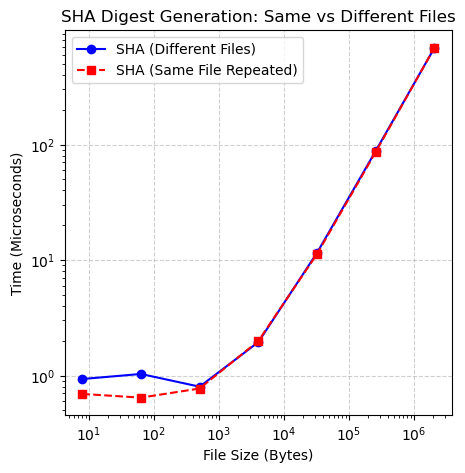

In [91]:
sha_times_different = collect_times_different_files(directory, sizes, iterations=100)
sha_times_same = collect_times_same_file(directory, sizes, iterations=100)

def compare_variation(directory, sizes, iterations=100):

    plt.figure(figsize=(5, 5))
    plt.plot(sizes, sha_times_different, marker='o', linestyle='-', color='b', label="SHA (Different Files)")
    plt.plot(sizes, sha_times_same, marker='s', linestyle='--', color='r', label="SHA (Same File Repeated)")

    plt.xlabel("File Size (Bytes)")
    plt.ylabel("Time (Microseconds)")
    plt.title("SHA Digest Generation: Same vs Different Files")
    plt.xscale("log") 
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()
compare_variation(directory, sizes, iterations=100)

Calculating the confidence interval of the results obtained.

In [92]:
def print_confidence_interval(times, confidence=0.99):

    mean = np.mean(times)
    std_err = sts.sem(times) 
    dof = len(times) - 1  

    conf_interval = sts.t.interval(confidence, dof, loc=mean, scale=std_err)

    print(f"Mean Hashing Time: {mean:.6f} µs")
    print(f"{confidence*100:.0f}% Confidence Interval: ({conf_interval[0]:.6f}, {conf_interval[1]:.6f}) µs")
    
print_confidence_interval(sha_times_different)

Mean Hashing Time: 113.252889 µs
99% Confidence Interval: (-244.845075, 471.350852) µs
